# BerlinMOD Queries

So far we have replicated the BerlinMOD Pymeos tutorial using Pyspark. Now we will execute a subset of the BerlinMOD queries.

In [1]:
cd "../mobilitydb-berlinmod-sf0.1/"

/data/mobilitydb-berlinmod-sf0.1


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
ls

Archivo.zip          periods.csv*  trips_sample_pymeos.csv  vehicles_small.csv
brussels_region.csv  points.csv*   trips_small.csv
instants.csv*        regions.csv*  vehicle_ids.txt
licences.csv*        trips.csv*    vehicles.csv*


In [3]:
rm -R spark-warehouse/

/bin/rm: cannot remove 'spark-warehouse/': No such file or directory


## Imports

In [4]:
from pymeos import *
from pymeos.plotters import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pysparkmeos.UDT.MeosDatatype import *
from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pysparkmeos.partitions.kdtree_partitioner import KDTreePartition
from pysparkmeos.partitions.adaptive_partitioner import AdaptiveBinsPartitioner
from pysparkmeos.utils.udt_appender import *
from pysparkmeos.utils.utils import *


from pysparkmeos.UDF.udf import *
from pysparkmeos.UDTF.BerlinMOD import *

import random, datetime, os, sys
from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import pandas as pd
import shapely.geometry as shp

import matplotlib.pyplot as plt
import numpy as np
from shapely import wkb, box, from_wkb
from typing import Union
from time import time

## Spark Initialization

In [5]:
def startspark():
    # Initialize PyMEOS
    pymeos_initialize("UTC")
    
    os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
    os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
    os.environ['PYSPARK_PYTHON'] = sys.executable
    
    # Initialize a Spark session
    spark = SparkSession.builder \
        .appName("BerlinMOD with PySpark") \
        .master("local[3]") \
        .config("spark.default.parallelism", 12) \
        .config("spark.executor.memory", "3g") \
        .config("spark.executor.cores", 1) \
        .config("spark.driver.memory", "2g") \
        .config("spark.driver.maxResultSize", 0) \
        .config("spark.sql.execution.arrow.maxRecordsPerBatch", "500") \
        .config("spark.sql.allowMultipleTableArguments.enabled", True) \
        .getOrCreate()
        
    # Append the UDT mapping to the PyMEOS classes
    udt_append()
    
    # Get the value of 'spark.default.parallelism'
    default_parallelism = spark.sparkContext.getConf().get("spark.default.parallelism")
    print(f"spark.default.parallelism: {default_parallelism}")

    # Register udfs in Spark SQL
    register_udfs_under_spark_sql(spark)

    # Register the udtfs in Spark SQL
    register_udtfs_under_spark_sql(spark)

    return spark

spark = startspark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/19 15:53:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


spark.default.parallelism: 12


## Load Tables
We will use the power of Spark SQL to read in the raw dataframes and then create the tables.

In [6]:
ls

Archivo.zip          periods.csv*  trips_sample_pymeos.csv  vehicles_small.csv
brussels_region.csv  points.csv*   trips_small.csv
instants.csv*        regions.csv*  vehicle_ids.txt
licences.csv*        trips.csv*    vehicles.csv*


In [7]:
def load_table(
    spark, 
    path, 
    tablename, 
    partition_key=None, 
    transformation_query=None,
    partition_query = None,
    partitioner_class = None,
    partitioner_args = {},
    num_buckets = 1,
    **kwargs
):
    spark.sql(f"""DROP TABLE IF EXISTS {tablename}""")
    spark.sql(f"""DROP TABLE IF EXISTS {tablename}Raw""")
    spark.sql(f"""DROP TABLE IF EXISTS {tablename}NoCache""")
    spark.sql(f"""DROP VIEW IF EXISTS {tablename}RawNoCache""")

    print("Reading raw csv ", path)
    rawdf = spark.read.csv(path, **kwargs)
    print("Creating temp view of raw table")
    rawdf.createOrReplaceTempView(f"{tablename}RawNoCache")
    rawdf.limit(1).show()

    print("Schema and statistics of raw table")
    rawdf.printSchema()
    rawdf.describe().show()
    print(f"Creating final table {tablename} based on {tablename}RawNoCache, partitioned by {partition_key}.")
    if transformation_query:
        rawdf = spark.sql(transformation_query)
        #rawdf.show()
        rawdf.createOrReplaceTempView(f"{tablename}RawNoCache")
        spark.sql(f"CACHE TABLE {tablename}Raw SELECT * FROM {tablename}RawNoCache")
        spark.sql(f"SELECT * FROM {tablename}Raw LIMIT 5").show()
        #spark.catalog.dropTempView(f"{tablename}RawNoCache")
    else:
        spark.sql(f"CACHE TABLE {tablename}Raw SELECT * FROM {tablename}RawNoCache")
        #spark.catalog.dropTempView(f"{tablename}RawNoCache")
    partitioner = None
    if partition_query:
        bounds = rawdf.rdd.mapPartitions(lambda b: bounds_calculate_map(b, colname='trip')).reduce(bounds_calculate_reduce)
        print("Bounds: ", bounds)
        if "movingObjects" in partitioner_args:
            sample = spark.sql(f"SELECT trip FROM {tablename}Raw")
            partitioner_args['movingObjects'] = [row.trip for row in sample.collect()]
        if "movingobjects" in partitioner_args:
            sample = spark.sql(f"SELECT trip FROM {tablename}Raw")
            partitioner_args['movingobjects'] = [row.trip for row in sample.collect()]
        partitioner = partitioner_class(bounds=bounds, **partitioner_args)
        grid = partitioner.as_spark_table()
        grid.cache()
        grid.show()
        grid.createOrReplaceTempView("grid")
        print("Creating partitioned table... ")
        partitionedTable = spark.sql(partition_query)
        partitionedTable.createOrReplaceTempView(f"{tablename}Raw")


    start = time()
    
    if partition_key:
        df = spark.sql(f"""
        CREATE TABLE {tablename}NoCache
        USING parquet
        CLUSTERED BY ({partition_key}) INTO {num_buckets} BUCKETS
        AS SELECT * FROM {tablename}Raw
        """)
    else:
        df = spark.sql(f"""
        CREATE TABLE {tablename}NoCache
        USING parquet
        AS SELECT * FROM {tablename}Raw
        """)
        
    end = time()
    
    print(f"Final table created in {end-start} seconds")

    spark.sql(f"CACHE TABLE {tablename} SELECT * FROM {tablename}NoCache")

    df = spark.table(f"{tablename}")
    
    print(f"Final table {tablename} schema:")
    df.printSchema()
    
    #Drop the temporary view
    #spark.catalog.dropTempView(f"{tablename}Raw")
    return df, (start, end, end-start)


def load_all_tables(configs):
    tables = {}
    stats = {}
    for tablename, config in configs.items():
        table, stat = load_table(**config)
        tables[tablename] = table
        stats[tablename] = stat
    return tables, stats

### Instants

In [8]:
transinstants = """
    SELECT * 
    FROM InstantsUDTF(
        TABLE(
                SELECT 
                    instantid AS trajectory_id,
                    tboolinst_from_base_time(instant, TRUE) AS movingobject, 
                    (SELECT collect_list(tile) FROM grid) AS tiles, 
                    (SELECT collect_list(tileid) FROM grid) AS tileids
                FROM instantsRawNoCache
        )
    )
"""

#instants, statsinstants = load_table(spark, "instants.csv", 'instants', transformation_query=transinstants, inferSchema=True, header=True)
#instants.show()

### Licences

In [9]:
#licences, statslicences = load_table(spark, "licences.csv", 'licences', inferSchema=True, header=True)
#licences.show()

### Periods

In [10]:
transperiod = """
    SELECT * 
    FROM PeriodsUDTF(
        TABLE(
                SELECT 
                    periodid AS trajectory_id,
                    beginp,
                    endp,
                    tstzspan(period) AS movingobject,
                    (SELECT collect_list(tile) FROM grid) AS tiles, 
                    (SELECT collect_list(tileid) FROM grid) AS tileids
                FROM periodsRawNoCache
        )
    )
"""

#periods, statsperiods = load_table(spark, "periods.csv", 'points', transformation_query=transperiod, inferSchema=True, header=True)
#periods.show()

### Points

In [11]:
transpoints = """
    SELECT * 
    FROM PointsUDTF(
        TABLE(
                SELECT 
                    pointid AS trajectory_id, 
                    posx, 
                    posy, 
                    geometry_from_hexwkb(geom) AS movingobject, 
                    (SELECT collect_list(tile) FROM grid) AS tiles, 
                    (SELECT collect_list(tileid) FROM grid) AS tileids
                FROM pointsRawNoCache
        )
    )
"""

#points, statspoints = load_table(spark, "points.csv", 'points', transformation_query=transpoints, inferSchema=True, header=True)
#points.show()

### Regions

In [12]:
transregions = """
    SELECT * 
    FROM RegionsUDTF(
        TABLE(
                SELECT 
                    regionid AS trajectory_id, 
                    geometry_from_hexwkb(geom) AS movingobject, 
                    (SELECT collect_list(tile) FROM grid) AS tiles, 
                    (SELECT collect_list(tileid) FROM grid) AS tileids
                FROM regionsRawNoCache
        )
    )
"""

#regions, statsregions = load_table(spark, "regions.csv", 'regions', transformation_query=transregions, inferSchema=True, header=True)
#regions.show()

### Trips
Note: Use trips_small for testing.

In [13]:
# We need to add the transformation query to the trips table and inject it to the config.
parttrips = """
    SELECT * 
    FROM TripsUDTF(
        TABLE(
                SELECT 
                    tripid AS trajectory_id,
                    vehid,
                    day,
                    seqno,
                    sourcenode,
                    targetnode,
                    trip AS movingobject,
                    trajectory,
                    licence,
                    (SELECT collect_list(tile) FROM grid) AS tiles, 
                    (SELECT collect_list(tileid) FROM grid) AS tileids
                FROM tripsRaw
        )
    )
"""

In [14]:

transtrips = "SELECT tripid, vehid, day, seqno, sourcenode, targetnode, trip_from_hexwkb(trip) AS trip, geometry_from_hexwkb(trajectory) AS trajectory, licence FROM tripsRawNoCache"

"""
trips, statstrips = load_table(
    spark, "trips_small.csv", 'trips', 
    transformation_query=transtrips,
    partition_key= 'partitionKey',
    partition_query=parttrips,
    partitioner_class=GridPartition,
    partitioner_args = {'cells_per_side': 3},
    inferSchema=True,
    header=True
)
trips.show()
"""

'\ntrips, statstrips = load_table(\n    spark, "trips_small.csv", \'trips\', \n    transformation_query=transtrips,\n    partition_key= \'partitionKey\',\n    partition_query=parttrips,\n    partitioner_class=GridPartition,\n    partitioner_args = {\'cells_per_side\': 3},\n    inferSchema=True,\n    header=True\n)\ntrips.show()\n'

### Vehicles
Note: Also read vehicles_small for testing.

In [15]:
#vehicles, statsvehicles = load_table(spark, "vehicles_small.csv", 'vehicles', inferSchema=True, header=True)
#vehicles.show()

## Queries

First queries take a general approach and are only used to measure overall performance.

In [16]:
from time import time
def query_exec(query, spark, execute=True, explain=False, explainmode=''):
    plan = None
    if explain:
        plan = spark.sql(f"EXPLAIN {explainmode} {query}").collect()[0].plan
    result = spark.sql(query)
    start = time()
    if execute:
        result.show()
    end = time()
    print("Query execution time: ", end-start, " seconds.")
    return result, (start, end, end-start), plan


def retrieve_exec_stats(queries, starts, ends, durations, plans):
    return pd.DataFrame({"queries": queries, "start": starts, "end": ends, "duration": durations, "plan": plans})


def run_all_queries(queries, spark, execute=True, explain=True, explainmode='', printplan=False):
    """ Utility function to run all queries through subsequent experiments """
    qdfs = []
    starts = []
    ends = []
    durations = []
    plans = []
    for querytext in queries:
        qdf, qstats, plan = query_exec(querytext, spark, execute, explain, explainmode)
        qdfs.append(qdf)
        starts.append(qstats[0])
        ends.append(qstats[1])
        durations.append(qstats[2])
        plans.append(plan)
        if printplan:
            print(plan)
    exec_stats = retrieve_exec_stats(queries, starts, ends, durations, plans)
    return qdfs, exec_stats

### Query 1: What are the models of the vehicles with licence plate numbers from QueryLicences?

In [17]:
%%time
querytext1 = """
    SELECT l.licence, v.model
    FROM licences l, vehicles v
    WHERE l.licence = v.licence
"""
# query1(spark).show()

#q1, q1stats, plan1 = query_exec(querytext1, spark, explain=True)
#if plan1:
#    print(plan1)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 14.5 µs


### Query 2: How many vehicles exist that are 'passenger' cars?

In [18]:
%%time
querytext2 = """
    SELECT COUNT(licence) AS PassengerCarCount
    FROM vehicles
    WHERE type='passenger'
"""

#q2, q2stats, plan2 = query_exec(querytext2, spark, explain=True)
#if plan2:
#    print(plan2)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.15 µs


### Query 3: Where have the vehicles with licences from QueryLicences1 been at each of the instants from QueryInstants1?

In [19]:
%%time

from datetime import datetime

querytext3 = """
    WITH
    veh_w_lic AS (
        SELECT v.vehid, l.licence, v.model
        FROM licences l, vehicles v
        WHERE l.licence = v.licence
    ),
    veh_trips AS (
        SELECT t.* 
        FROM veh_w_lic vw, trips t
        WHERE t.vehid = vw.vehid
    )
    SELECT vt.vehid, vt.movingobjectid, vt.movingobject, i.instant, tpoint_at(vt.movingobject, i.instant) AS pos
    FROM veh_trips vt INNER JOIN instants i ON i.tileid=vt.tileid
    WHERE tpoint_at(vt.movingobject, i.instant) IS NOT NULL
"""

#q3, q3stats, plan3 = query_exec(querytext3, spark, explain=True)
#if plan3:
#    print(plan3)

CPU times: user 12 µs, sys: 12 µs, total: 24 µs
Wall time: 27.9 µs


### Query 4: Which licence plate numbers belong to vehicles that have passed the points from QueryPoints?

In [20]:
%%time

querytext4 = """
    WITH
    
    vehids_intersect AS (
        SELECT t.vehid
        FROM trips t INNER JOIN points p ON (t.tileid=p.tileid)
        WHERE 
            ever_intersects(t.movingobject, p.geom) = TRUE
    )
    SELECT vi.vehid, v.licence
    FROM vehids_intersect vi INNER JOIN vehicles v ON (vi.vehid=v.vehid)
"""

q4, q4stats, plan4 = query_exec(querytext4, spark, explain=True)
#if plan4:
#    print(plan4)

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `trips` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 6 pos 13;
'WithCTE
:- 'CTERelationDef 1, false
:  +- 'SubqueryAlias vehids_intersect
:     +- 'Project ['t.vehid]
:        +- 'Filter ('ever_intersects('t.movingobject, 'p.geom) = true)
:           +- 'Join Inner, ('t.tileid = 'p.tileid)
:              :- 'SubqueryAlias t
:              :  +- 'UnresolvedRelation [trips], [], false
:              +- 'SubqueryAlias p
:                 +- 'UnresolvedRelation [points], [], false
+- 'Project ['vi.vehid, 'v.licence]
   +- 'Join Inner, ('vi.vehid = 'v.vehid)
      :- 'SubqueryAlias vi
      :  +- 'SubqueryAlias vehids_intersect
      :     +- 'CTERelationRef 1, false, false
      +- 'SubqueryAlias v
         +- 'UnresolvedRelation [vehicles], [], false


### Query 5: What is the minimum distance between places, where a vehicle with a licence from QueryLicences1 and a vehicle with a licence from QueryLicences2 have been?

In [21]:
querytext5 = """
    WITH ql1vehids AS (
        SELECT vehicles.licence, vehicles.vehid 
        FROM vehicles, querylicences1
        WHERE vehicles.licence = querylicences1.licence   
    ),
    ql2vehids AS (
        SELECT vehicles.licence, vehicles.vehid 
        FROM vehicles, querylicences2
        WHERE vehicles.licence = querylicences2.licence   
    ),
    ql1trips AS (
        SELECT ql1vehids.licence, trips.* 
        FROM trips, ql1vehids
        WHERE trips.vehid = ql1vehids.vehid
    ),
    ql2trips AS (
        SELECT ql2vehids.licence, trips.*
        FROM trips, ql2vehids
        WHERE trips.vehid = ql2vehids.vehid
    ),
    distances AS (
        SELECT
            t1.licence AS t1licence,
            t2.licence AS t2licence,
            t1.movingobjectid AS t1tripid,
            t2.movingobjectid AS t2tripid,
            t1.tileid AS t1tileid,
            t2.tileid AS t2tileid,
            min_distance(t1.movingobject, t2.movingobject) AS min_dist
        FROM 
            ql1trips t1 INNER JOIN ql2trips t2 ON (
                t1.vehid != t2.vehid AND 
                t1.movingobjectid != t2.movingobjectid AND
                min_distance(t1.movingobject, t2.movingobject) IS NOT NULL
            )
    )
    SELECT 
        t1licence,
        t2licence,
        t1tripid,
        t2tripid,
        MIN(min_dist)
    FROM distances
    GROUP BY t1licence, t2licence, t1tripid, t2tripid
"""

#q5, q5stats, plan5 = query_exec(querytext5, spark, explain=True)
#if plan5:
#    print(plan5)

### Query 6: What are the pairs of licence plate numbers of “trucks”, that have ever been as close as 10m or less to each other?

In [22]:
querytext6 = """
    WITH trucks AS (
        SELECT vehid, licence
        FROM vehicles
        WHERE type='truck'
    ),
    trucktrips AS (
        SELECT truck.vehid, truck.licence, trips.movingobject, trips.tileid, trips.movingobjectid
        FROM trucks truck INNER JOIN trips ON (truck.vehid=trips.vehid)
    )
    SELECT t1.licence, t2.licence, t1.movingobjectid, t2.movingobjectid, t1.tileid, t2.tileid, nearest_approach_distance(t1.movingobject, t2.movingobject) AS licence_pairs
    FROM 
        trucktrips t1 INNER JOIN trucktrips t2 ON (
            t1.vehid != t2.vehid)
    WHERE nearest_approach_distance(t1.movingobject, t2.movingobject) BETWEEN 0.1 AND 10.1
    ORDER BY licence_pairs DESC
"""

#q6, q6stats, plan6 = query_exec(querytext6, spark, explain=True)
#if plan6:
#    print(plan6)

### Query 11: Query 11 Which vehicles passed a point from QueryPoints1 at one of the instants from QueryInstants1? 

In [23]:
%%time

querytext11 = """
    WITH atinstants AS (
        SELECT t.vehid, t.movingobjectid, tpoint_at(t.movingobject, i.instant, TRUE) AS atinstant, t.tileid
        FROM trips t INNER JOIN instants i ON (t.tileid=i.tileid)
        WHERE tpoint_at(t.movingobject, i.instant, TRUE) IS NOT NULL
    ),
    atpoints AS (
        SELECT t.vehid, t.movingobjectid, ever_intersects(t.movingobject, ati.atinstant) AS atpoint, t.tileid
        FROM trips t INNER JOIN atinstants ati ON (t.tileid=ati.tileid)
        WHERE ever_intersects(t.movingobject, ati.atinstant) = TRUE
    )
    SELECT DISTINCT vehid FROM atpoints
"""

#q11, q11stats, plan11 = query_exec(querytext11, spark, explain=True)
#if plan11:
#    print(plan11)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 13.8 µs


### Query 13: Which vehicles travelled within one of the regions from QueryRegions1 during the periods from QueryPeriods1?

In [24]:
%%time

querytext13 = """
    WITH atperiods AS (
        SELECT t.vehid, t.movingobjectid, at_period(t.movingobject, p.period) AS atperiod, t.tileid
        FROM trips t INNER JOIN periods p ON (t.tileid=p.tileid)
        WHERE at_period(t.movingobject, p.period) IS NOT NULL
    ),
    intersections AS (
        SELECT atp.vehid, atp.movingobjectid, at_geom(atp.atperiod, r.geom) AS atgeom
        FROM atperiods atp INNER JOIN regions r ON (atp.tileid=r.tileid)
        WHERE at_geom(atp.atperiod, r.geom) IS NOT NULL
    )
    SELECT DISTINCT vehid FROM intersections
"""

#q13, q13stats, plan13 = query_exec(querytext13, spark, explain=True)
#if plan13:
#    print(plan13)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.68 µs


In [25]:
queries = [querytext1, querytext2, querytext3, querytext4, querytext5, querytext6]

## Experiments

### Experiment 1: Run Queries ASIS

In [26]:
run_exp_1 = False

#### Create Tables

In [27]:
rm -R spark-warehouse/

In [28]:
configs_exp1 = {
    'instants': {'spark': spark, 'path': 'instants.csv', 'tablename': 'instants', 'inferSchema': True, 'header': True},
    'licences': {'spark': spark, 'path': 'licences.csv', 'tablename': 'licences', 'inferSchema': True, 'header': True},
    'periods':  {'spark': spark, 'path': 'periods.csv', 'tablename': 'periods', 'transformation_query': transperiod, 'inferSchema': True, 'header': True},
    'points':   {'spark': spark, 'path': 'points.csv', 'tablename': 'points', 'transformation_query': transpoints, 'inferSchema': True, 'header': True},
    'regions':  {'spark': spark, 'path': 'regions.csv', 'tablename': 'regions', 'transformation_query':transregions, 'inferSchema': True, 'header': True},
    'trips':    {'spark': spark, 'path': 'trips_small.csv', 'tablename': 'trips', 'transformation_query':transtrips, 'inferSchema': True, 'header': True},
    'vehicles': {'spark': spark, 'path': 'vehicles_small.csv', 'tablename': 'vehicles', 'inferSchema': True, 'header': True}
}

In [29]:
if run_exp_1:
    tables, stats = load_all_tables(configs_exp1)

In [30]:
@F.udtf(returnType="num: int, squared: int")
class SquareNumbers:
    def eval(self, start: int, end: int):
        for num in range(start, end + 1):
            yield (num, num * num)

SquareNumbers(F.lit(1), F.lit(3)).show()

+---+-------+
|num|squared|
+---+-------+
|  1|      1|
|  2|      4|
|  3|      9|
+---+-------+



In [31]:
"""
 |-- tripid: integer (nullable = true)
 |-- vehid: integer (nullable = true)
 |-- day: date (nullable = true)
 |-- seqno: integer (nullable = true)
 |-- sourcenode: integer (nullable = true)
 |-- targetnode: integer (nullable = true)
 |-- trip: pythonuserdefined (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)
"""
schema = StructType([
    StructField("point", TGeomPointInstUDT())
])
@F.udtf(returnType=schema)
class ExplodeGeomSeq:
    def eval(self, trip: TGeomPointSeqWrap):
        #print(trip['trip'])
        #trip = trip.trip
        pymeos_initialize()
        instants = trip['trip'].instants()
        for i in instants:
            yield i,

spark.udtf.register("explodeGeomSeq", ExplodeGeomSeq)

In [32]:
if run_exp_1:
    spark.sql("SELECT * FROM explodeGeomSeq(TABLE(SELECT trip FROM trips))").show()

#### Execute Queries

In [33]:
if run_exp_1:
    qdfs_exp1, stats_exp1 = run_all_queries(queries, spark, explain=True, printplan=True)

In [34]:
if run_exp_1:
    for (_id, rdd) in spark.sparkContext._jsc.getPersistentRDDs().items():
        rdd.unpersist()
        print("Unpersisted {} rdd".format(_id))
spark.stop()

### Experiment 2: Partition Trips by vehid, HashPartitioning

In [35]:
run_exp_2 = False

In [36]:
rm -R rm -R spark-warehouse/

/bin/rm: cannot remove 'rm': No such file or directory
/bin/rm: cannot remove 'spark-warehouse/': No such file or directory


In [37]:
if run_exp_2:
    spark = startspark()

#### Create Tables

In [38]:
configs_exp2 = {
    'instants': {'spark': spark, 'path': 'instants.csv', 'tablename': 'instants', 'inferSchema': True, 'header': True},
    'licences': {'spark': spark, 'path': 'licences.csv', 'tablename': 'licences', 'inferSchema': True, 'header': True},
    'periods':  {'spark': spark, 'path': 'periods.csv', 'tablename': 'periods', 'transformation_query': transperiod, 'inferSchema': True, 'header': True},
    'points':   {'spark': spark, 'path': 'points.csv', 'tablename': 'points', 'transformation_query': transpoints, 'inferSchema': True, 'header': True},
    'regions':  {'spark': spark, 'path': 'regions.csv', 'tablename': 'regions', 'transformation_query':transregions, 'inferSchema': True, 'header': True},
    'trips':    {'spark': spark, 'path': 'trips_small.csv', 'tablename': 'trips', 'partition_key': 'vehid', 'transformation_query':transtrips, 'inferSchema': True, 'header': True},
    'vehicles': {'spark': spark, 'path': 'vehicles_small.csv', 'tablename': 'vehicles', 'inferSchema': True, 'header': True}
}

In [39]:
if run_exp_2:
    tables, stats = load_all_tables(configs_exp2)

#### Execute Queries

In [40]:
if run_exp_2:
    qdfs_exp2, stats_exp2 = run_all_queries(queries, spark, explain=True, printplan=True)

In [41]:
#spark.stop()

### Experiment 3: Partition by Trip, RegularGrid

In [42]:
run_exp_3 = False

In [43]:
rm -R rm -R spark-warehouse/

/bin/rm: cannot remove 'rm': No such file or directory
/bin/rm: cannot remove 'spark-warehouse/': No such file or directory


In [44]:
if run_exp_3:
    spark = startspark()

In [45]:
# Load first trips so that we now have the bounds of the database in the grid table.
configs_exp3 = {
    'trips':    {
        'spark': spark, 
        'path': 'trips_small.csv', 
        'tablename': 'trips', 
        'partition_key': 'tileid', 
        'transformation_query':transtrips,
        'partition_query': parttrips,
        'partitioner_class': GridPartition,
        'partitioner_args': {'cells_per_side': 8},
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'instants': {
        'spark': spark, 
        'path': 'instants.csv', 
        'tablename': 'instants',
        'transformation_query': transinstants,
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'licences': {'spark': spark, 'path': 'licences.csv', 'tablename': 'licences', 'inferSchema': True, 'header': True},
    'periods':  {
        'spark': spark, 
        'path': 'periods.csv', 
        'tablename': 'periods', 
        'transformation_query': transperiod, 
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'points':   {
        'spark': spark, 
        'path': 'points.csv', 
        'tablename': 'points', 
        'transformation_query': transpoints,
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'regions':  {
        'spark': spark, 
        'path': 'regions.csv', 
        'tablename': 'regions', 
        'transformation_query':transregions, 
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'vehicles': {
        'spark': spark, 
        'path': 'vehicles_small.csv', 
        'tablename': 'vehicles', 
        'inferSchema': True, 
        'header': True}
}

In [46]:
if run_exp_3:    
    tables, stats = load_all_tables(configs_exp3)

    querylicences1 = spark.sql("""
    SELECT licence
    FROM vehicles
    WHERE vehid=17
    LIMIT 1
    """)
    querylicences1.cache().createOrReplaceTempView("querylicences1")
    
    querylicences2 = spark.sql("""
    SELECT licence
    FROM vehicles
    WHERE vehid=1
    LIMIT 1
    """)
    querylicences2.cache().createOrReplaceTempView("querylicences2")

#### Execute Queries

In [47]:
if run_exp_3:
    qdfs_exp3, stats_exp3 = run_all_queries(queries, spark, explain=True, printplan=True)

### Experiment 4: Partition by Trip, KDTreePartitioning

In [48]:
run_exp_4 = False

In [49]:
rm -R rm -R spark-warehouse/

/bin/rm: cannot remove 'rm': No such file or directory
/bin/rm: cannot remove 'spark-warehouse/': No such file or directory


In [50]:
if run_exp_4:
    spark = startspark()

In [51]:
# Load first trips so that we now have the bounds of the database in the grid table.
configs_exp4 = {
    'trips':    {
        'spark': spark, 
        'path': 'trips_small.csv', 
        'tablename': 'trips', 
        'partition_key': 'tileid', 
        'transformation_query':transtrips,
        'partition_query': parttrips,
        'partitioner_class': KDTreePartition,
        'partitioner_args': {
            'movingObjects': None, 
            'dimensions': ['x', 'y'], 
            'max_depth': 8
        },
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'instants': {
        'spark': spark, 
        'path': 'instants.csv', 
        'tablename': 'instants',
        'transformation_query': transinstants,
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'licences': {'spark': spark, 'path': 'licences.csv', 'tablename': 'licences', 'inferSchema': True, 'header': True},
    'periods':  {
        'spark': spark, 
        'path': 'periods.csv', 
        'tablename': 'periods', 
        'transformation_query': transperiod, 
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'points':   {
        'spark': spark, 
        'path': 'points.csv', 
        'tablename': 'points', 
        'transformation_query': transpoints,
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'regions':  {
        'spark': spark, 
        'path': 'regions.csv', 
        'tablename': 'regions', 
        'transformation_query':transregions, 
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'vehicles': {
        'spark': spark, 
        'path': 'vehicles_small.csv', 
        'tablename': 'vehicles', 
        'inferSchema': True, 
        'header': True}
}

In [52]:
if run_exp_4:
    tables, stats = load_all_tables(configs_exp4)

    querylicences1 = spark.sql("""
    SELECT licence
    FROM vehicles
    WHERE vehid=17
    LIMIT 1
    """)
    querylicences1.cache().createOrReplaceTempView("querylicences1")
    
    querylicences2 = spark.sql("""
    SELECT licence
    FROM vehicles
    WHERE vehid=1
    LIMIT 1
    """)
    querylicences2.cache().createOrReplaceTempView("querylicences2")

#### Execute Queries

In [53]:
if run_exp_4:
    qdfs_exp4, stats_exp4 = run_all_queries(queries, spark, explain=True, printplan=True)

### Experiment 5: Partition by Trip, AdaptiveBinsPartitioning

In [54]:
run_exp_5 = True

In [55]:
rm -R rm -R spark-warehouse/

/bin/rm: cannot remove 'rm': No such file or directory
/bin/rm: cannot remove 'spark-warehouse/': No such file or directory


In [56]:
if run_exp_5:
    spark = startspark()

spark.default.parallelism: 12


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 43910)
Traceback (most recent call last):
  File "/usr/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.9/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 271, in accum_updates
    num_updates = read_int(self.rf

In [57]:
# Load first trips so that we now have the bounds of the database in the grid table.
configs_exp5 = {
    'trips':    {
        'spark': spark, 
        'path': 'trips_small.csv', 
        'tablename': 'trips', 
        'partition_key': 'tileid', 
        'transformation_query':transtrips,
        'partition_query': parttrips,
        'partitioner_class': AdaptiveBinsPartitioner,
        'partitioner_args': {
            'movingobjects': None, 
            'num_tiles': 8,
            'dimensions': ['x', 'y', 't'], 
            'utc': 'UTC'
        },
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'instants': {
        'spark': spark, 
        'path': 'instants.csv', 
        'tablename': 'instants',
        'transformation_query': transinstants,
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'licences': {'spark': spark, 'path': 'licences.csv', 'tablename': 'licences', 'inferSchema': True, 'header': True},
    'periods':  {
        'spark': spark, 
        'path': 'periods.csv', 
        'tablename': 'periods', 
        'transformation_query': transperiod, 
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'points':   {
        'spark': spark, 
        'path': 'points.csv', 
        'tablename': 'points', 
        'transformation_query': transpoints,
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'regions':  {
        'spark': spark, 
        'path': 'regions.csv', 
        'tablename': 'regions', 
        'transformation_query':transregions, 
        'num_buckets': 8,
        'inferSchema': True, 
        'header': True},
    'vehicles': {
        'spark': spark, 
        'path': 'vehicles_small.csv', 
        'tablename': 'vehicles', 
        'inferSchema': True, 
        'header': True}
}

In [58]:
if run_exp_5:
    tables, stats = load_all_tables(configs_exp5)

    querylicences1 = spark.sql("""
    SELECT licence
    FROM vehicles
    WHERE vehid=17
    LIMIT 1
    """)
    querylicences1.cache().createOrReplaceTempView("querylicences1")
    
    querylicences2 = spark.sql("""
    SELECT licence
    FROM vehicles
    WHERE vehid=1
    LIMIT 1
    """)
    querylicences2.cache().createOrReplaceTempView("querylicences2")

Reading raw csv  trips_small.csv


Creating temp view of raw table
+------+-----+----------+-----+----------+----------+--------------------+--------------------+-------+
|tripid|vehid|       day|seqno|sourcenode|targetnode|                trip|          trajectory|licence|
+------+-----+----------+-----+----------+----------+--------------------+--------------------+-------+
|     1|    1|2020-06-01|    1|     79113|     66276|[0101000020110F00...|0102000020110F000...|   NULL|
+------+-----+----------+-----+----------+----------+--------------------+--------------------+-------+

Schema and statistics of raw table
root
 |-- tripid: integer (nullable = true)
 |-- vehid: integer (nullable = true)
 |-- day: date (nullable = true)
 |-- seqno: integer (nullable = true)
 |-- sourcenode: integer (nullable = true)
 |-- targetnode: integer (nullable = true)
 |-- trip: string (nullable = true)
 |-- trajectory: string (nullable = true)
 |-- licence: string (nullable = true)



24/06/19 15:54:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+-------+
|summary|            tripid|            vehid|             seqno|        sourcenode|        targetnode|                trip|          trajectory|licence|
+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+-------+
|  count|               124|              124|               124|               124|               124|                 124|                 124|      0|
|   mean| 405.9032258064516|14.42741935483871| 2.943548387096774|          36600.25|          36600.25|                NULL|                NULL|   NULL|
| stddev|243.83028948596683|8.369683374548373|2.3798012465853966|26819.557657976246|26819.557657976246|                NULL|                NULL|   NULL|
|    min|                 1|                1|                 1|           

+------+-----+----------+-----+----------+----------+--------------------+--------------------+-------+
|tripid|vehid|       day|seqno|sourcenode|targetnode|                trip|          trajectory|licence|
+------+-----+----------+-----+----------+----------+--------------------+--------------------+-------+
|     1|    1|2020-06-01|    1|     79113|     66276|[POINT(496253.840...|LINESTRING (49625...|   NULL|
|     2|    1|2020-06-01|    2|     66276|     79113|[POINT(481241.171...|LINESTRING (48124...|   NULL|
|     3|    1|2020-06-02|    1|     79113|     66276|[POINT(496253.840...|LINESTRING (49625...|   NULL|
|     4|    1|2020-06-02|    2|     66276|     79113|[POINT(481241.171...|LINESTRING (48124...|   NULL|
|     5|    1|2020-06-03|    1|     79113|     66276|[POINT(496253.840...|LINESTRING (49625...|   NULL|
+------+-----+----------+-----+----------+----------+--------------------+--------------------+-------+



Bounds:  STBOX XT(((473277.05262936745,6579811.389156611),(498784.34433982597,6606871.682578203)),[2020-06-01 06:01:41.054+00, 2020-06-11 19:49:59.511256+00])


+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((473277...|
|     1|STBOX XT(((477938...|
|     2|STBOX XT(((481622...|
|     3|STBOX XT(((484659...|
|     4|STBOX XT(((488402...|
|     5|STBOX XT(((490042...|
|     6|STBOX XT(((491553...|
|     7|STBOX XT(((496379...|
|     8|STBOX XT(((473277...|
|     9|STBOX XT(((477938...|
|    10|STBOX XT(((481622...|
|    11|STBOX XT(((484659...|
|    12|STBOX XT(((488402...|
|    13|STBOX XT(((490042...|
|    14|STBOX XT(((491553...|
|    15|STBOX XT(((496379...|
|    16|STBOX XT(((473277...|
|    17|STBOX XT(((477938...|
|    18|STBOX XT(((481622...|
|    19|STBOX XT(((484659...|
+------+--------------------+
only showing top 20 rows

Creating partitioned table... 


Final table created in 36.904613733291626 seconds


Final table trips schema:
root
 |-- vehid: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- seqno: integer (nullable = true)
 |-- sourcenode: integer (nullable = true)
 |-- targetnode: string (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)
 |-- license: string (nullable = true)
 |-- movingobjectid: string (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- movingobject: pythonuserdefined (nullable = true)

Reading raw csv  instants.csv


Creating temp view of raw table
+---------+--------------------+
|instantid|             instant|
+---------+--------------------+
|        1|2020-06-01 19:44:...|
+---------+--------------------+

Schema and statistics of raw table
root
 |-- instantid: integer (nullable = true)
 |-- instant: timestamp (nullable = true)

+-------+------------------+
|summary|         instantid|
+-------+------------------+
|  count|               100|
|   mean|              50.5|
| stddev|29.011491975882016|
|    min|                 1|
|    max|               100|
+-------+------------------+

Creating final table instants based on instantsRawNoCache, partitioned by None.


+---------+------+--------------------+
|instantid|tileid|             instant|
+---------+------+--------------------+
|        1|     0|t@2020-06-01 19:4...|
|        1|     1|t@2020-06-01 19:4...|
|        1|     2|t@2020-06-01 19:4...|
|        1|     3|t@2020-06-01 19:4...|
|        1|     4|t@2020-06-01 19:4...|
+---------+------+--------------------+



Final table created in 2.681377649307251 seconds
Final table instants schema:
root
 |-- instantid: integer (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- instant: pythonuserdefined (nullable = true)

Reading raw csv  licences.csv
Creating temp view of raw table
+---------+--------+-----+
|licenceid| licence|vehid|
+---------+--------+-----+
|        1|B-QS 276|  276|
+---------+--------+-----+

Schema and statistics of raw table
root
 |-- licenceid: integer (nullable = true)
 |-- licence: string (nullable = true)
 |-- vehid: integer (nullable = true)



+-------+------------------+--------+------------------+
|summary|         licenceid| licence|             vehid|
+-------+------------------+--------+------------------+
|  count|               101|     101|               101|
|   mean|              51.0|    NULL|319.46534653465346|
| stddev|29.300170647967224|    NULL| 175.0106604956644|
|    min|                 1|B-BJ 115|                 9|
|    max|               101|B-[U 177|               622|
+-------+------------------+--------+------------------+

Creating final table licences based on licencesRawNoCache, partitioned by None.


Final table created in 1.418025016784668 seconds
Final table licences schema:
root
 |-- licenceid: integer (nullable = true)
 |-- licence: string (nullable = true)
 |-- vehid: integer (nullable = true)

Reading raw csv  periods.csv
Creating temp view of raw table
+--------+--------------------+--------------------+--------------------+
|periodid|              beginp|                endp|              period|
+--------+--------------------+--------------------+--------------------+
|       1|2020-06-09 11:15:...|2020-06-09 20:38:...|[2020-06-09 13:15...|
+--------+--------------------+--------------------+--------------------+

Schema and statistics of raw table
root
 |-- periodid: integer (nullable = true)
 |-- beginp: timestamp (nullable = true)
 |-- endp: timestamp (nullable = true)
 |-- period: string (nullable = true)



+-------+------------------+--------------------+
|summary|          periodid|              period|
+-------+------------------+--------------------+
|  count|               100|                 100|
|   mean|              50.5|                NULL|
| stddev|29.011491975882016|                NULL|
|    min|                 1|[2020-06-01 00:45...|
|    max|               100|[2020-06-11 21:18...|
+-------+------------------+--------------------+

Creating final table periods based on periodsRawNoCache, partitioned by None.


+--------------------+--------------------+--------+------+--------------------+
|              beginp|                endp|periodid|tileid|              period|
+--------------------+--------------------+--------+------+--------------------+
|2020-06-09 11:15:...|2020-06-09 20:38:...|       1|   384|[2020-06-09 11:15...|
|2020-06-09 11:15:...|2020-06-09 20:38:...|       1|   385|[2020-06-09 11:15...|
|2020-06-09 11:15:...|2020-06-09 20:38:...|       1|   386|[2020-06-09 11:15...|
|2020-06-09 11:15:...|2020-06-09 20:38:...|       1|   387|[2020-06-09 11:15...|
|2020-06-09 11:15:...|2020-06-09 20:38:...|       1|   388|[2020-06-09 11:15...|
+--------------------+--------------------+--------+------+--------------------+



Final table created in 3.0076849460601807 seconds
Final table periods schema:
root
 |-- beginp: timestamp (nullable = true)
 |-- endp: timestamp (nullable = true)
 |-- periodid: integer (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- period: pythonuserdefined (nullable = true)

Reading raw csv  points.csv
Creating temp view of raw table
+-------+-----------------+-----------------+--------------------+
|pointid|             posx|             posy|                geom|
+-------+-----------------+-----------------+--------------------+
|      1|476191.0852037612|6589454.831155596|0101000020110F000...|
+-------+-----------------+-----------------+--------------------+

Schema and statistics of raw table
root
 |-- pointid: integer (nullable = true)
 |-- posx: double (nullable = true)
 |-- posy: double (nullable = true)
 |-- geom: string (nullable = true)



+-------+------------------+-----------------+-----------------+--------------------+
|summary|           pointid|             posx|             posy|                geom|
+-------+------------------+-----------------+-----------------+--------------------+
|  count|               100|              100|              100|                 100|
|   mean|              50.5|486384.3413598945|6594038.933758076|                NULL|
| stddev|29.011491975882016|7200.526060474747|6552.156274876073|                NULL|
|    min|                 1|472428.0634008836|6577421.541139536|0101000020110F000...|
|    max|               100| 498913.875699313|6607119.513588189|0101000020110F000...|
+-------+------------------+-----------------+-----------------+--------------------+

Creating final table points based on pointsRawNoCache, partitioned by None.


+-----------------+-----------------+-------+------+--------------------+
|             posx|             posy|pointid|tileid|                geom|
+-----------------+-----------------+-------+------+--------------------+
|476191.0852037612|6589454.831155596|      1|     8|POINT (476191.085...|
|476191.0852037612|6589454.831155596|      1|    72|POINT (476191.085...|
|476191.0852037612|6589454.831155596|      1|   136|POINT (476191.085...|
|476191.0852037612|6589454.831155596|      1|   200|POINT (476191.085...|
|476191.0852037612|6589454.831155596|      1|   264|POINT (476191.085...|
+-----------------+-----------------+-------+------+--------------------+



Final table created in 2.0225472450256348 seconds
Final table points schema:
root
 |-- posx: double (nullable = true)
 |-- posy: double (nullable = true)
 |-- pointid: integer (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- geom: pythonuserdefined (nullable = true)

Reading raw csv  regions.csv
Creating temp view of raw table
+--------+--------------------+
|regionid|                geom|
+--------+--------------------+
|       1|0103000020110F000...|
+--------+--------------------+

Schema and statistics of raw table
root
 |-- regionid: integer (nullable = true)
 |-- geom: string (nullable = true)

+-------+------------------+--------------------+
|summary|          regionid|                geom|
+-------+------------------+--------------------+
|  count|               100|                 100|
|   mean|              50.5|                NULL|
| stddev|29.011491975882016|                NULL|
|    min|                 1|0103000020110F000...|
|    max|               100|0

+--------+------+--------------------+
|regionid|tileid|                geom|
+--------+------+--------------------+
|       1|     2|POLYGON ((483571....|
|       1|    66|POLYGON ((483571....|
|       1|   130|POLYGON ((483571....|
|       1|   194|POLYGON ((483571....|
|       1|   258|POLYGON ((483571....|
+--------+------+--------------------+



Final table created in 2.0943076610565186 seconds
Final table regions schema:
root
 |-- regionid: integer (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- geom: pythonuserdefined (nullable = true)

Reading raw csv  vehicles_small.csv
Creating temp view of raw table
+-----+-------+---------+-----------+
|vehid|licence|     type|      model|
+-----+-------+---------+-----------+
|    1| B-EF 1|passenger|Sachsenring|
+-----+-------+---------+-----------+

Schema and statistics of raw table
root
 |-- vehid: integer (nullable = true)
 |-- licence: string (nullable = true)
 |-- type: string (nullable = true)
 |-- model: string (nullable = true)



+-------+----------------+-------+-----+--------+
|summary|           vehid|licence| type|   model|
+-------+----------------+-------+-----+--------+
|  count|               4|      4|    4|       4|
|   mean|           14.25|   NULL| NULL|    NULL|
| stddev|9.63932916061417|   NULL| NULL|    NULL|
|    min|               1|B-CJ 17|  bus|Multicar|
|    max|              24|B-PZ 15|truck|Wartburg|
+-------+----------------+-------+-----+--------+

Creating final table vehicles based on vehiclesRawNoCache, partitioned by None.


Final table created in 2.823655366897583 seconds
Final table vehicles schema:
root
 |-- vehid: integer (nullable = true)
 |-- licence: string (nullable = true)
 |-- type: string (nullable = true)
 |-- model: string (nullable = true)



#### Execute Queries

In [ ]:
if run_exp_5:
    qdfs_exp5, stats_exp5 = run_all_queries(queries, spark, explain=True, printplan=True)

## Mapping the regions and trips

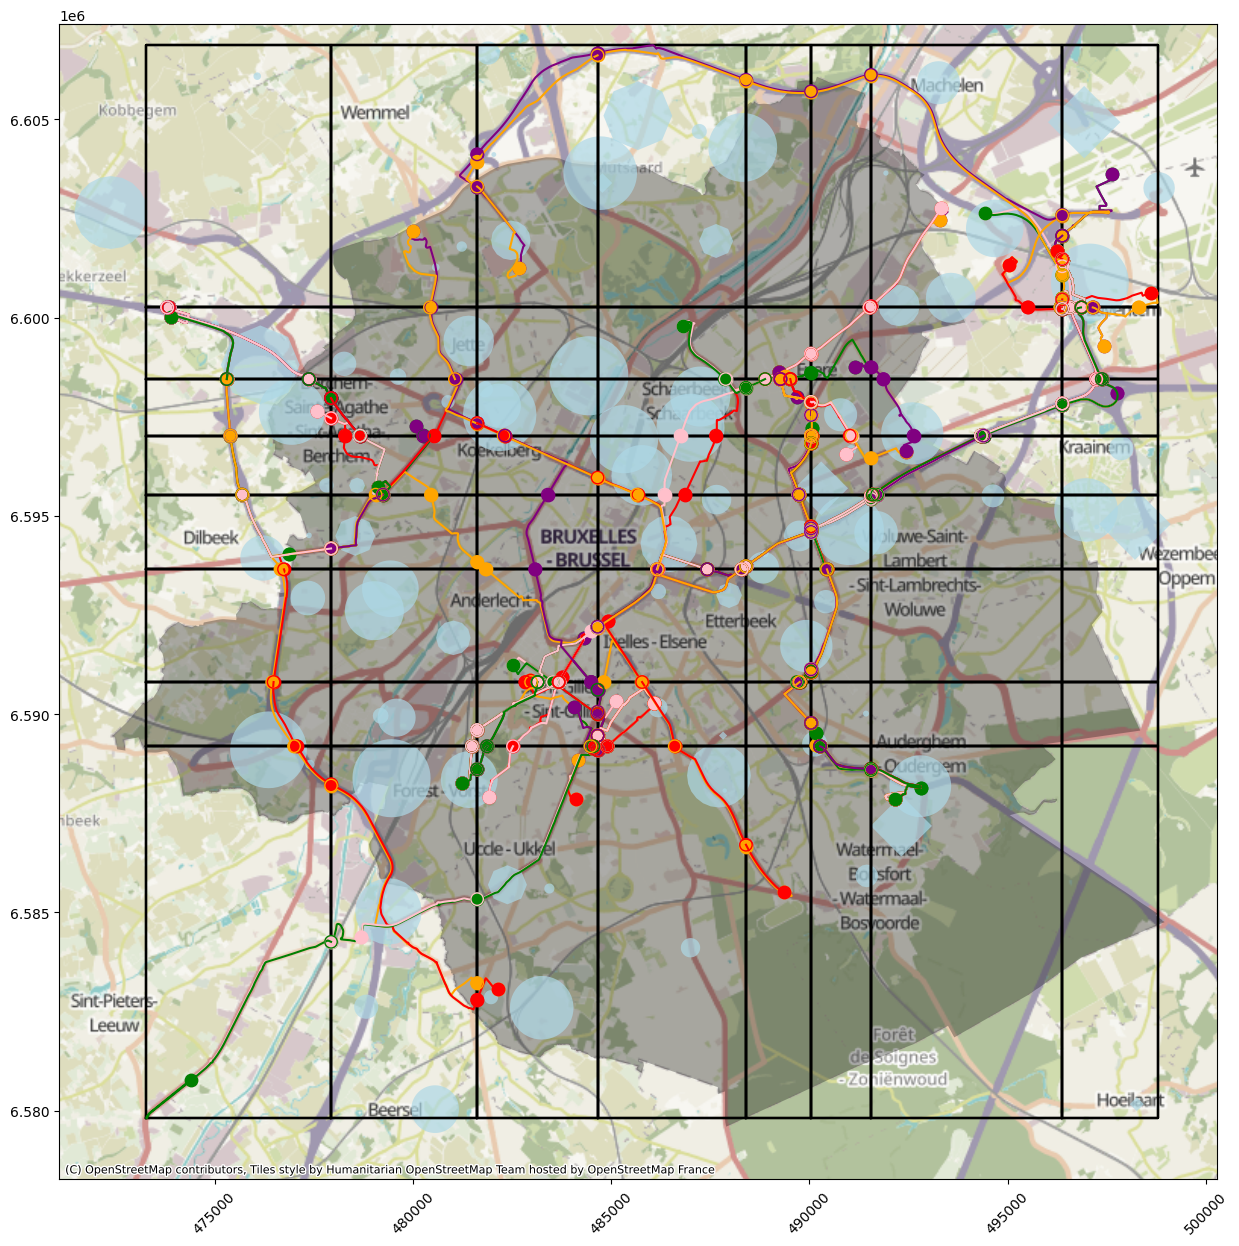

In [59]:
_, ax = plt.subplots(1, 1, figsize=(15, 15))
brussels = pd.read_csv(
    "brussels_region.csv", converters={"geom": partial(wkb.loads, hex=True)}
)
brussels = gpd.GeoDataFrame(brussels, geometry="geom")
brussels_geom = brussels["geom"][0]
brussels.plot(ax=ax, alpha=0.3, color='black')
cx.add_basemap(ax)
grid = spark.table('grid')

for gridrow in grid.toLocalIterator():
    gridrow.tile.plot_xy(axes=ax, color="black", draw_filling=False)

regions = spark.table('regions').select("regionid", "geom").distinct()

for regionrow in regions.toLocalIterator():
    myPoly = gpd.GeoSeries([regionrow.geom])
    myPoly.plot(ax=ax, alpha=0.7, color='lightblue')
    
trips = spark.table('trips').select('movingobjectid', 'movingobject')
colors = ['orange', 'red', 'pink', 'green', 'purple']
for triprow in trips.toLocalIterator():
    TemporalPointSequenceSetPlotter.plot_xy(
        triprow.movingobject, axes=ax, show_markers=True, show_grid=False, color=colors[int(triprow.movingobjectid) % len(colors)]
    )